# Problem 1.1: Application Layer Rerouting

Die kompletten Quellen sind auf [Github](https://github.com/captain-proton/aise/blob/master/nia/pycharm/exercise_1.py "NIA exercise 1") zu finden

### Programm

In [1]:
import itertools
import os
import re
import subprocess
import numpy
import matplotlib.pyplot as plt
import scipy.stats as stats

#### Konfiguration

In [2]:
class Config(object):
    def __init__(self):
        super().__init__()

conf = Config()
conf.hosts = (
    'uni-due.de',
    'whitehouse.gov',
    'icmp.org',
)
conf.log = os.path.join(os.getcwd(), 'ping.stdout.log')
conf.num_pings = 100
conf.histogram_bins = 20

#### Hilfsfunktionen

In [3]:
def __read_rtt(line: str):
    """
    Tries to read the ``time=...`` value with its unit that is normally output by a ping result.

    Example:
    
    ``64 bytes from addce0.uni-due.de (132.252.185.170): icmp_seq=1 ttl=121 time=19.7 ms``

    :param line: can be any string value
    :return: a dict with ``rtt`` and ``unit`` if a match in given line was found
    """
    m = re.search('time=(\d+(\.\d+)?)\s+(\w+)', line)
    if m:
        groups = m.groups()
        time = float(groups[0])
        unit = groups[2]
        return {
            'rtt': time,
            'unit': unit
        }


def __read_host(line: str):
    """
    Tries to read the host value of a string that is output by a ping line starting with ``PING``

    Example:

    ``PING uni-due.de (132.252.185.170) 56(84) bytes of data.``

    :param line: any string value
    :return: a hostname if one was found, None otherwise
    """
    m = re.search('^(PING\s)(\S+)', line)
    if m:
        groups = m.groups()
        return groups[1]

def __print_min_max_mean(iterable):
    print('{0:>12}: {1}'.format('Max', max(iterable)))
    print('{0:>12}: {1}'.format('Min', min(iterable)))
    print('{0:>12}: {1}'.format('Mean', numpy.round(numpy.mean(iterable), decimals=3)))
    

def __read_log():
    rtt_log = []
    with open(conf.log, mode='r') as log:
        current_host = None
        for line in log:
            rtt = __read_rtt(line)
            if rtt:
                rtt['host'] = current_host
                rtt_log.append(rtt)

            host = __read_host(line)
            if host:
                current_host = host
    return rtt_log

### 1.1.1 Statistiken

Es sollen die minimalen, maximalen und durchschnittlichen Werte der RTT einzelnen und zusammengenommen ausgegebene werden. Zusätzlich wird ein Histogram gezeigt.

In [4]:
log = __read_log()
times = [rtt['rtt'] for rtt in log]

__print_min_max_mean(times)

log = sorted(log, key=lambda t: t['host'])
for k, g in itertools.groupby(log, key=lambda t: t['host']):
    print('-'.join(['' for i in range(0, 80)]))
    print('{0:>12}: {1}'.format('Host', k))
    print()
    __print_min_max_mean([rtt['rtt'] for rtt in g])

         Max: 414.0
         Min: 17.4
        Mean: 84.865
-------------------------------------------------------------------------------
        Host: icmp.org

         Max: 414.0
         Min: 184.0
        Mean: 215.013
-------------------------------------------------------------------------------
        Host: uni-due.de

         Max: 111.0
         Min: 17.4
        Mean: 22.74
-------------------------------------------------------------------------------
        Host: whitehouse.gov

         Max: 127.0
         Min: 35.4
        Mean: 43.909


#### Histogram

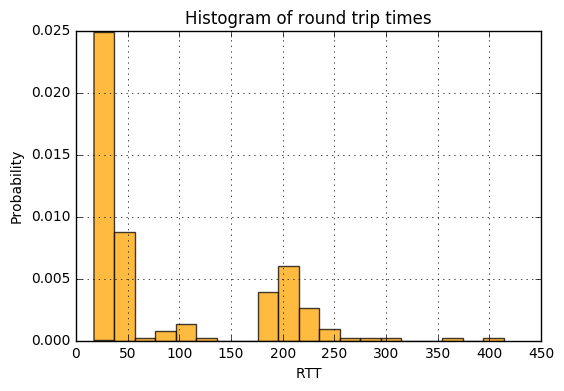

In [5]:
plt.hist(times, conf.histogram_bins, normed=1, facecolor='orange', alpha=0.75)

plt.xlabel('RTT')
plt.ylabel('Probability')
plt.title('Histogram of round trip times')
# plt.axis([min(times), max(times), 0, 0.03])
plt.grid(True)
plt.show()

#### CDF

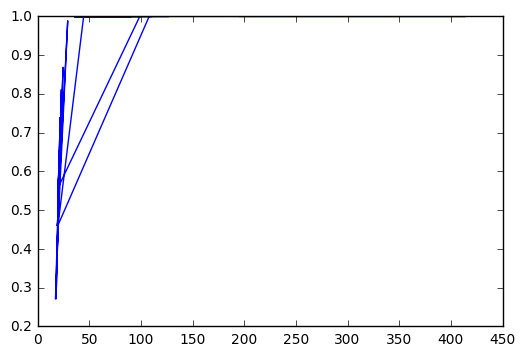

In [6]:
log = __read_log()
times = [rtt['rtt'] for rtt in log]
cdf = stats.binom.cdf
plt.plot(times, cdf(times, 100, 0.2))
plt.show()

## 1.1.3 CDF der Verzögerung D_abc